In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sys
sys.path.append('../')
# Scientific 

import numpy as np
import random

import Train
from tqdm import tqdm
import matplotlib.pyplot as plt

# Machine learning

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.utils import to_categorical

import temperature_scaling
from scipy.special import softmax
import xgboost

Using TensorFlow backend.


In [3]:
# Read in data wrt kic and fill etc.
NDAYS = -1
dataset = 'KIC'
accounting_for_TESS = False #True
df = pd.read_csv('../Colours_New_Gaps_output_data_noise_'+str(dataset)+'_'+str(NDAYS)+'_APOKASC.csv')
bad_kics = [10403036, 9846355, 5004660, 4936438, 6450613, 10597648, 5395942]
df = df[~df.KIC.isin(bad_kics)] 
print(np.shape(df))
# Set up training class
CLP = Train.Train(df, dataset, NDAYS)
# Preprocess
CLP.preprocess_data()
# Set up data for training
CLP.setup_for_training(features=['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag'])

# Extract the train and valid (used for validation) dataframes from the train_df
train_features, valid_features, y_train, y_valid = CLP.X_train.drop(['KIC', 'numax'], axis=1), CLP.X_test.drop(['KIC', 'numax'], axis=1), CLP.Y_train, CLP.Y_test

(8553, 17)
['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag']


/home/kuszi/.envs/venv/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
../Train.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['KIC'] = self.df['KIC'].astype(int)
/home/kuszi/.envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/kuszi/.envs/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWa

In [4]:
param_full = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.1,
                'gamma': 7.5,
                'max_depth': 3,
                'min_child_weight': 4,
                'subsample': 0.7,
                'colsample': 0.7,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}
param_180 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.375,
                'gamma': 7.5,
                'max_depth': 6,
                'min_child_weight': 1.0,
                'subsample': 0.5,
                'colsample': 0.5,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

param_80 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.275,
                'gamma': 7.5,
                'max_depth': 10,
                'min_child_weight': 2.0,
                'subsample': 0.85,
                'colsample': 0.85,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

param_27 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.025,
                'gamma': 7.5,
                'max_depth': 8,
                'min_child_weight': 3.0,
                'subsample': 0.5,
                'colsample': 0.85,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

In [5]:
if NDAYS == -1:
    param = param_full
elif NDAYS == 180:
    param = param_180
elif NDAYS == 80:
    param = param_80
elif NDAYS == 27:
    param = param_27
else:
    sys.exit()
bst = xgboost.Booster(param)
#bst.load_model('../Clumpiness-package/Code/-1random.model')
#bst.load_model('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/'+str(NDAYS)+'.model')
#best_iter = np.loadtxt('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/best_iter_'+str(NDAYS)+'.txt')
bst.load_model('../'+str(NDAYS)+'.model')
best_iter = np.loadtxt('../best_iter_'+str(NDAYS)+'.txt')
print(f"Best iter: {best_iter}")

Best iter: 962.0


In [6]:
if NDAYS == -1:
    df['running_var'] = np.log10(np.abs(df['running_var']))
    df = df[df['running_var'] < 2.5]
df.sample(frac=1).reset_index(drop=True)

predict_df = df[(df['ndata'] < ((180 * 86400.0)/(29.4*60))) | (df['evo'] == 6)]
predict_df = predict_df[predict_df['fill'] > 0.5]
if NDAYS == -1:
    df = df[df['ndata'] > ((180 * 86400.0)/(29.4*60))]
else:
    df = df[df['ndata'] > (((NDAYS/2) * 86400.0)/(29.4*60))]

df = df[df['fill'] > 0.5]
df = df[df['evo'] < 5]
#df = df.drop_duplicates('KIC')

X = df[['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag', 'mc']]
#X['var'] = X['var']**2
#X['mc'] = X['mc']**2
#X = pd.read_csv('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/random_feature_test.csv')
X = X.rename(index=str, columns={"var": r"$\log_{10}\sigma^{2}$", "mc": r"$\log_{10}\sigma^{2}_{\mathrm{diff}}$", "hoc": r"$\psi^{2}$", "abs_k_mag": r"$M_{K_{s}}$"})
#plt.hist(X.loc[X['y'] == 0,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 1,'rand'], bins=30, histtype='step', density=True);
#plt.hist(np.random.normal(size=len(X.loc[X['y'] == 1,'rand'])), bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 2,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 3,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 4,'rand'], bins=30, histtype='step', density=True);
#y = X['y'].astype(int)
#X = X.drop(['y'], axis=1)
print(X.drop(['KIC', 'numax'], axis=1).head())
y = df['evo'].astype(int)
print(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        stratify=y)
print(np.shape(X_test),np.shape(Y_test))
print(np.shape(X))

   $\log_{10}\sigma^{2}$        zc  $\psi^{2}$  $M_{K_{s}}$  \
1            1200.383678  0.032072    1.642052    -3.344805   
2             275.733887  0.189737    0.623509    -1.072591   
3             553.109516  0.069209    1.826779    -1.776589   
5             396.901835  0.122893    0.924548    -1.838557   
6             455.093275  0.090319    1.530439    -1.601088   

   $\log_{10}\sigma^{2}_{\mathrm{diff}}$  
1                             110.811879  
2                             157.945677  
3                             117.419228  
5                             154.485027  
6                             123.982521  
1       1
2       2
3       3
5       3
6       3
       ..
8555    4
8556    4
8557    4
8558    4
8559    4
Name: evo, Length: 7808, dtype: int64
(2343, 7) (2343,)
(7808, 7)


In [13]:
xg_train = xgboost.DMatrix(X_train.drop(['KIC', 'numax'], axis=1))#, label=Y_train.values)
xg_test = xgboost.DMatrix(X_test.drop(['KIC', 'numax'], axis=1))#, label=Y_test.values)
probs_train = bst.predict(xg_train, ntree_limit=best_iter)
probs_test = bst.predict(xg_test, ntree_limit=best_iter)

In [14]:
full_preds = np.c_[probs_test[:,:3].sum(axis=1), probs_test[:,3:]]

In [16]:
#print(predictions)
full_valid = CLP._create_full_class(Y_test)
full_pred = CLP._create_full_class(np.argmax(probs_test, axis=1))
# TODO: Add the importance for the selected features
#print("Score {0}".format(loss))
print("Accuracy {}".format(accuracy_score(Y_test, np.argmax(probs_test, axis=1))))
print("Full accuracy {}".format(accuracy_score(full_valid, full_pred)))
print(classification_report(Y_test, np.argmax(full_preds, axis=1)))
print(classification_report(full_valid, full_pred))

Accuracy 0.9159197609901836
Full accuracy 0.9265898420827998
              precision    recall  f1-score   support

           0       0.16      0.98      0.27       152
           1       0.00      0.01      0.00       160
           2       0.00      0.00      0.00       737
           3       0.00      0.00      0.00       727
           4       0.00      0.00      0.00       567

    accuracy                           0.06      2343
   macro avg       0.03      0.20      0.05      2343
weighted avg       0.01      0.06      0.02      2343

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1049
           1       0.84      0.96      0.90       727
           2       0.99      0.99      0.99       567

    accuracy                           0.93      2343
   macro avg       0.93      0.94      0.93      2343
weighted avg       0.93      0.93      0.93      2343



In [17]:
def make_model_diagrams(outputs, labels, n_bins=10):
    """
    outputs - a torch tensor (size n x num_classes) with the outputs from the final linear layer
    - NOT the softmaxes
    labels - a torch tensor (size n) with the labels
    """
    softmaxes = softmax(outputs, axis=1)
    confidences, predictions = np.max(softmaxes, axis=1), np.argmax(softmaxes, axis=1)
    #labels = to_categorical(labels.values)
    accuracies = (predictions == labels.values) * 1    
    #print(accuracies)
    # Reliability diagram
    bins = np.linspace(0, 1., n_bins + 1)
    #bins[-1] = 1.0001
    width = bins[1] - bins[0]
    #bin_indices = [confidences.ge(bin_lower) * confidences.lt(bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    bin_indices = [((confidences > bin_lower) & (confidences < bin_upper)) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    label_bins = [labels.values[bin_index] for bin_index in bin_indices]
    bin_corrects = np.array([np.mean(accuracies[bin_index]) for bin_index in bin_indices])
    bin_scores = np.array([np.mean(confidences[bin_index]) for bin_index in bin_indices])
    #print(label_bins)
    #print(bin_corrects)
    #print(bins[:-1][np.nanargmax(bin_corrects)])
    confs = plt.bar(bins[:-1], bin_corrects, width=width, edgecolor='k', align='edge')
    gaps = plt.bar(bins[:-1], (bin_scores - bin_corrects), bottom=bin_corrects, align='edge', color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    #plt.legend([confs, gaps], ['Outputs', 'Gap'], loc='best', fontsize='small')
    plt.xlim(0, 1)
    # Clean up
    plt.ylabel(r'Accuracy', fontsize=18)
    plt.xlabel(r'Confidence', fontsize=18)
    return bins[:-1], label_bins, bin_corrects

/home/kuszi/.envs/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kuszi/.envs/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kuszi/.envs/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


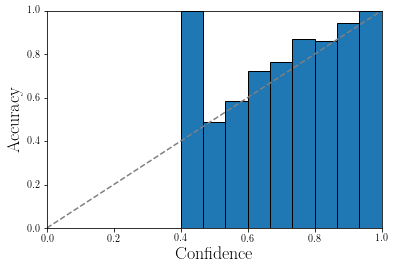

NameError: name 'new_model' is not defined

In [18]:
#fig = plt.figure(figsize=(8, 6))
bins, labs, corr = make_model_diagrams(bst.predict(xg_test, output_margin=True), Y_test, n_bins=15)
#plt.savefig('Reliability_plot_'+str(NDAYS)+'.pdf')
plt.show()
bins2, labs2, corr2 = make_model_diagrams(new_model.predict(xg_test), Y_test, n_bins=15)
#plt.savefig('Reliability_plot_corr_'+str(NDAYS)+'.pdf')


In [16]:
#list(zip(corr, bins, labs))

In [17]:
#fig = make_model_diagrams(gbm_model.predict(dvalid, output_margin=True), y_valid, n_bins=25)
#plt.savefig('/home/kuszlewicz/Dropbox/Reliability_plot.pdf')
#plt.show()
#fig = make_model_diagrams(new_model.predict(dvalid), y_valid, n_bins=25)

In [18]:
#plt.hist(np.max(softmax(new_model.predict(dvalid), axis=1), axis=1), bins=100, histtype='step', density=True);
#plt.hist(np.max(gbm_model.predict(dvalid), axis=1), bins=100, histtype='step', density=True);

In [19]:
def lorentzian(f, a, b):
    zeta = 2 * np.sqrt(2) / np.pi
    return (zeta * a**2 / b) / (1 + (f/b)**4)

def granulation(f, numax):
    a = 3382 * numax ** -0.609
    b1 = 0.317 * numax ** 0.970
    b2 = 0.948 * numax ** 0.992
    
    model = lorentzian(f, a, b1) + lorentzian(f, a, b2)
    integrated_power = np.sum(model) * (f[1]-f[0])
    return integrated_power
    
def gaussian(f, numax):
    denv = 0.66 * numax ** 0.88
    sigma = denv / (2 * np.sqrt(2*np.log(2)))
    Henv = 2.03e7 * numax**-2.38
    model = Henv * np.exp(-(f-numax)**2 / (2*sigma**2))
    return np.sum(model)*(f[1]-f[0])

In [20]:
f = np.linspace(0, 283.4, 32000)
numax = np.linspace(1, 300, 1000)

In [21]:
int_gran = np.zeros_like(numax)
int_osc = np.zeros_like(numax)
for i in range(len(numax)):
    int_gran[i] = granulation(f, numax[i])
    int_osc[i] = gaussian(f, numax[i])

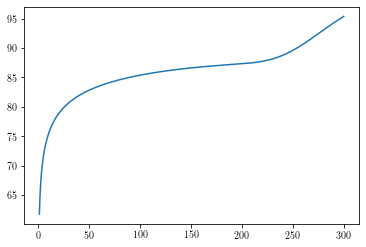

In [22]:
plt.plot(numax, int_gran/(int_osc + int_gran) * 100)

In [23]:
zc_gauss = np.array([ 0.49912 ,  0.666367,  0.732079,  0.769869,  0.795083,  0.81284 ,
        0.827098,  0.838291,  0.847576,  0.855565,  0.862341,  0.868062,
        0.873031,  0.877556,  0.881678])

In [24]:
for i in range(len(zc_gauss)-1):
    print(zc_gauss[i+1]-zc_gauss[i])

0.16724700000000003
0.06571199999999999
0.03778999999999999
0.02521399999999996
0.017757000000000023
0.014257999999999993
0.011193000000000008
0.009284999999999988
0.007989000000000024
0.006776000000000004
0.005720999999999976
0.004969000000000001
0.004525000000000001
0.004121999999999959


In [69]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def find_nearest(array, value):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def compute_ROC(Y_test, yprob, class_names=None):
    if class_names is None:
        class_names = ['LLRGB', 'HLRGB', 'ConfRGB', 'CHeB', 'Noise']
    colours = ['C'+str(i) for i in range(len(class_names))]
    assert len(class_names) == np.shape(yprob)[1]
    # Binarize Labels
    y = label_binarize(Y_test, classes=np.linspace(0, len(class_names)-1, len(class_names)).astype(int))
    # Compute auc/roc etc.
    fpr = dict()
    tpr = dict()
    J = dict()
    roc_auc = dict()
    thresholds = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y[:,i], yprob[:,i])
        J[i] = tpr[i] - fpr[i]
        roc_auc[i] = auc(fpr[i], tpr[i])

    #print(thresholds)
    for i in range(n_classes):
        idx = np.argmax(J[i])
        best_threshold = thresholds[i][idx]
        print(f"Best threshold for class {i}: {best_threshold} with J of {np.max(J[i])}")
        plt.plot(fpr[i], tpr[i], lw=2, color=colours[i],
        label=r'ROC curve of class {} (area = {:0.3f})'.format(class_names[i], roc_auc[i]))
        cond = find_nearest(thresholds[i], 1/3) #(abs(thresholds[i]-(1/3)) < 5e-3)
        #print(fpr[i][cond], tpr[i][cond])
        plt.scatter(fpr[i][idx], tpr[i][idx], marker='o', color=colours[i])
        #plt.axvline(fpr[i][cond], color=colours[i], linestyle='--')
        #break
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim(0.0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel(r'False Positive Rate', fontsize=18)
    plt.ylabel(r'True Positive Rate', fontsize=18)
    plt.legend(loc='lower right')
    

Best threshold for class 0: 0.4598701596260071 with J of 0.8506489583809118
Best threshold for class 1: 0.5044034719467163 with J of 0.8758809770248002
Best threshold for class 2: 0.2469554841518402 with J of 0.9895669479002812
(2343,)


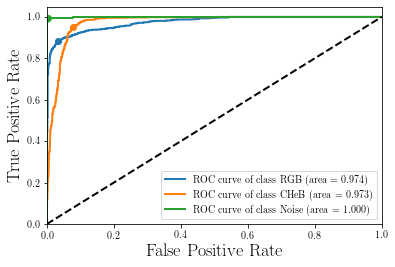

In [70]:
compute_ROC(full_valid, full_preds, class_names=['RGB', 'CHeB', 'Noise'])
print(np.shape(full_valid))

In [66]:
# Recompute accuracy using those new thresholds
best_threshs = np.array([0.4598701596260071, 0.5044034719467163, 0.2469554841518402])
#full_preds[full_preds[:,1] > best_1]
new_pred = np.zeros(len(full_preds))+3
for i in range(len(full_preds)):
    idx, max_prob = np.argmax(full_preds[i,:]), np.max(full_preds[i,:])
    if max_prob > best_threshs[idx]:
        new_pred[i] = int(idx)

In [72]:
new_pred#, full_valid
print(f"New accuracy is {accuracy_score(new_pred[new_pred < 3], full_valid[new_pred < 3])}")
print(f"Fraction of stars 'unclassified': {len(new_pred[new_pred == 3])/len(new_pred) * 100}")

New accuracy is 0.9280205655526992
Fraction of stars 'unclassified': 0.3841229193341869


In [74]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import label_binarize
# Use label_binarize to be multi-label like settings
Y_test = label_binarize(full_valid, classes=[0, 1, 2])
n_classes = Y_test.shape[1]

# For each class
precision = dict()
recall = dict()
average_precision = dict()
thresholds = dict()
fscore = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(Y_test[:, i],
                                                        full_preds[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], full_preds[:, i])
    fscore[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix = np.argmax(fscore)
    best_threshold = thresholds[i][ix]
    print(f"Best threshold for class {i}: {best_threshold} with f-score of {np.max(fscore[i])}")

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    full_preds.ravel())
average_precision["micro"] = average_precision_score(Y_test, full_preds,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Best threshold for class 0: 0.07256215810775757 with f-score of 0.9183572488866898
Best threshold for class 1: 0.007641256786882877 with f-score of 0.8975864318330072
Best threshold for class 2: 0.005952170584350824 with f-score of 0.9911971830985915
Average precision score, micro-averaged over all classes: 0.98


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.98')

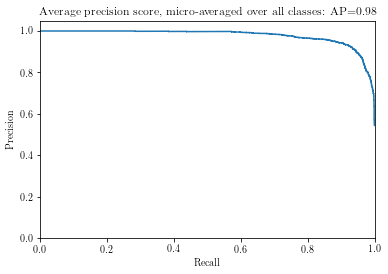

In [152]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

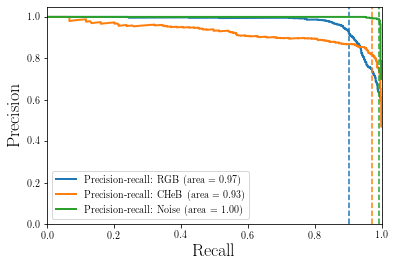

In [155]:
from itertools import cycle
# setup plot details
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colours = ['C0', 'C1', 'C2']
class_names = ['RGB', 'CHeB', 'Noise']

#plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
#for f_score in f_scores:
#    x = np.linspace(0.01, 1)
#    y = f_score * x / (2 * x - f_score)
#    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

#lines.append(l)
#labels.append('iso-f1 curves')
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#lines.append(l)
#labels.append('micro-average Precision-recall (area = {0:0.2f})'
#              ''.format(average_precision["micro"]))
for i in range(n_classes):
    l, = plt.plot(recall[i], precision[i], color=colours[i], lw=2)
    lines.append(l)
    labels.append('Precision-recall: {0} (area = {1:0.2f})'
                  ''.format(class_names[i], average_precision[i]))
    idx = find_nearest(thresholds[i], 1/3)
    plt.axvline(recall[i][idx], color=colours[i], linestyle='--')

    
#fig = plt.gcf()
#fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel(r'Recall', fontsize=18)
plt.ylabel(r'Precision', fontsize=18)
#plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels)#, loc=(0, -.38), prop=dict(size=14))


plt.show()

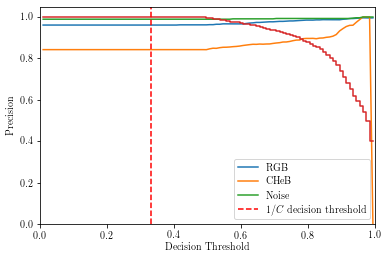

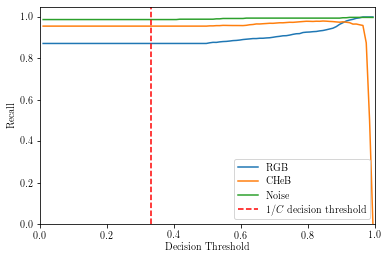

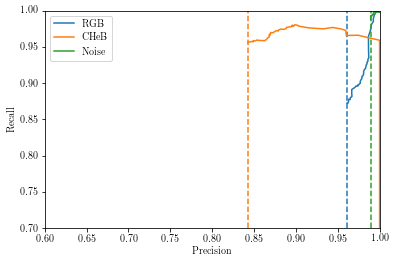

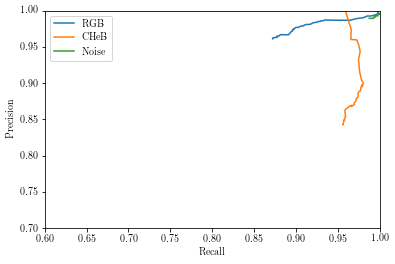

In [138]:
class_names = ['RGB', 'CHeB', 'Noise']
for i in range(len(class_names)):
    plt.plot(thresholds, pr[:,i], label=class_names[i])
plt.step(thresholds, nsamples)
plt.axvline(1/3, color='r', linestyle='--', label=r'$1/C$ decision threshold')
plt.xlabel(r'Decision Threshold')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend(loc='best')
#plt.savefig('Precision_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
for i in range(len(class_names)):
    plt.plot(thresholds, rc[:,i], label=class_names[i])
plt.axvline(1/3, color='r', linestyle='--', label=r'$1/C$ decision threshold')
plt.xlabel(r'Decision Threshold')
plt.ylabel('Recall')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend(loc='best')
#plt.savefig('Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
colour = ['C0', 'C1', 'C2']
for i in range(len(class_names)):
    plt.plot(pr[:,i], rc[:,i], label=class_names[i])
    idx = find_nearest(thresholds, 1/3)
    plt.axvline(pr[:,i][idx], color=colour[i], linestyle='--')
plt.xlabel(r'Precision')
plt.ylabel('Recall')
plt.xlim(0.6, 1)
plt.ylim(0.7, 1)
plt.legend(loc='best')
#plt.savefig('Precision_Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
for i in range(len(class_names)):
    plt.plot(rc[:,i], pr[:,i], label=class_names[i])
    idx = find_nearest(thresholds, 1/3)
#    plt.axvline(pr[:-5,i][idx], color=colour[i], linestyle='--')
plt.ylabel(r'Precision')
plt.xlabel('Recall')
plt.xlim(0.6, 1)
plt.ylim(0.7, 1)
plt.legend(loc='best')
#plt.savefig('Precision_Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()